*La base des TDs pour le cours "Classification des données" a été prise du cours en ligne "Open Machine Learning Course" (https://mlcourse.ai/, auteur Yury Kashnitsky)*

# <center> TD 2 : Classification, arbres de décision et k plus proches voisins (KNN)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns 
sns.set()

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

from IPython.display import Image

%config InlineBackend.figure_format = 'retina'

## 1. Arbres de décision

### La classe DecisionTreeClassifier dans Scikit-learn

Les principaux paramètres de la classe [`sklearn.tree.DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) sont les suivants:

- `max_depth` - la profondeur maximale de l'arbre;
- `max_features` - le nombre maximal de caractéristiques avec lesquelles rechercher la meilleure partition (nécessaire avec un grand nombre de caractéristiques car il serait "coûteux" de rechercher des partitions pour *toutes* les caractéristiques);
- `min_samples_leaf` - nombre minimal d'échantillons dans une feuille. Ce paramètre empêche de créer des arbres où n'importe quelle feuille n'aurait que quelques membres.

Les paramètres de l'arbre doivent être définis en fonction des données d'entrée. Cette opération est généralement effectuée à l'aide d'une *validation croisée*.

### A. Exemple de la classification sur les données synthétiques

Considérons l’entraînement d’un arbre de décision sur des données synthétiques. Nous allons générer des échantillons à partir de deux classes, les deux sont de distributions normales (ou gaussiennes) mais avec des moyennes différentes.

In [ ]:
# first class
np.random.seed(17)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# adding second class
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

Nous allons visualiser les données. De manière informelle, le problème de classification dans ce cas est de construire une "bonne" limite séparant les deux classes (les points rouges des points jaunes). Dans ce cas, l’apprentissage automatique se résume à choisir une bonne frontière de séparation. Une ligne droite sera trop simple alors qu'une courbe complexe se faufilant autour de chaque point rouge sera trop complexe et nous conduira à faire des erreurs sur de nouveaux échantillons. Intuitivement, une limite lisse, ou au moins une ligne droite ou un hyperplan, conviendrait parfaitement pour les nouvelles données.

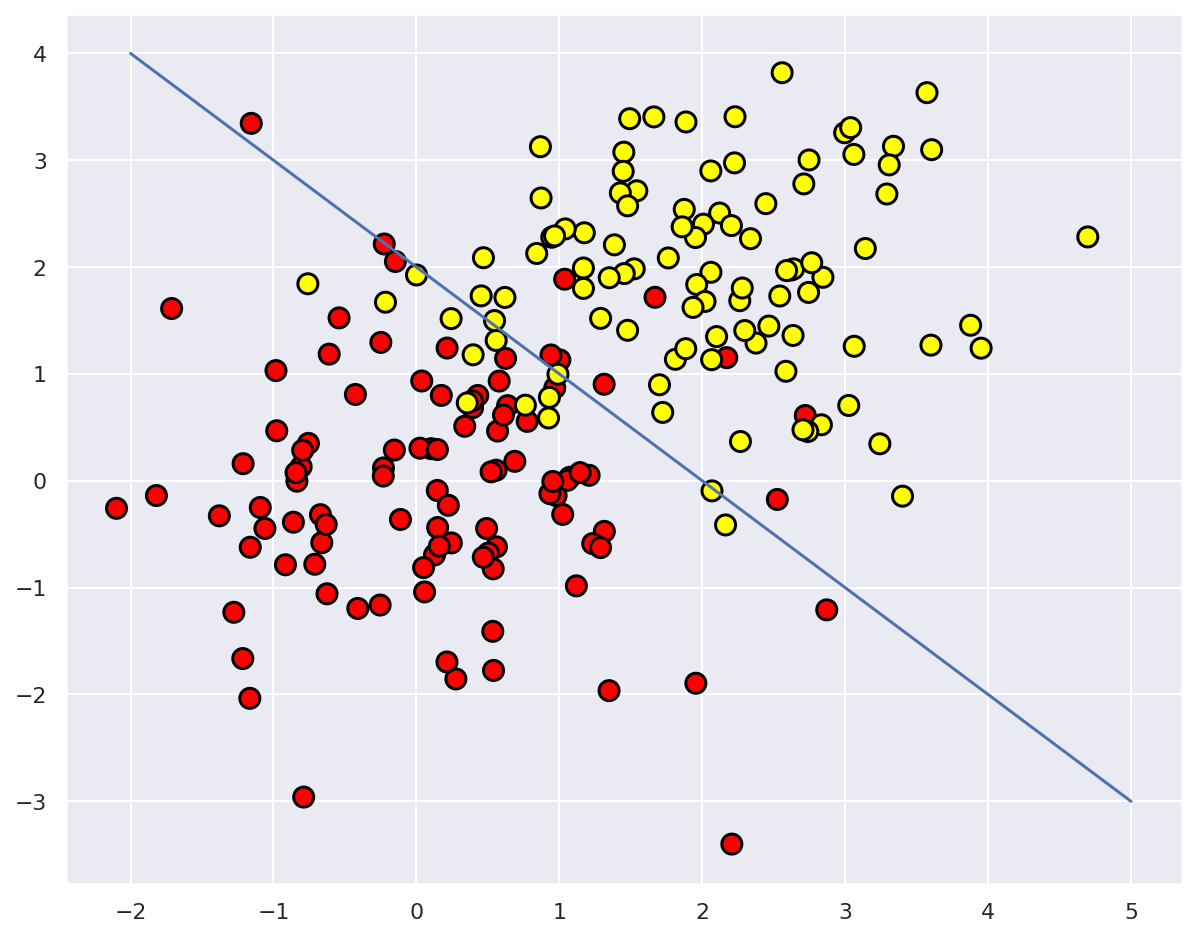

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,6), range(4,-4,-1));

Essayons de séparer ces deux classes en entraînant un arbre de décision via `Sklearn`. Nous allons utiliser le paramètre `max_depth` qui limite la profondeur de l'arbre. Visualisons la limite de séparation résultante.

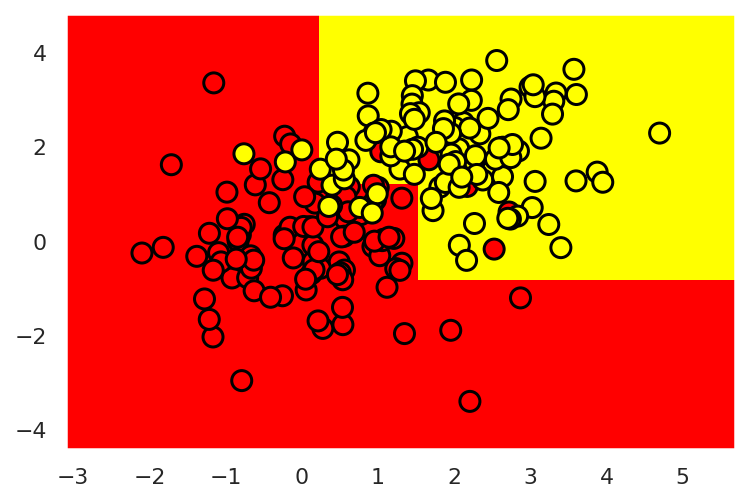

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Ecrivons une fonction auxiliaire qui retournera la grille pour plus de visualisation.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, 
                                  random_state=17)

# entraînement de l'arbre
clf_tree.fit(train_data, train_labels)

# code pour représenter la surface de séparation
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);

Et à quoi ressemble l'arbre lui-même? Nous voyons que l’arbre "coupe" l’espace en 8 rectangles, c’est-à-dire que l’arbre a 8 feuilles. Au sein de chaque rectangle, l’arbre effectuera la prédiction en fonction de l’étiquette majoritaire des objets qu’il contient.

In [ ]:
#!pip install pydotplus, Pillow

import pydotplus 
from sklearn.tree import export_graphviz

def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)

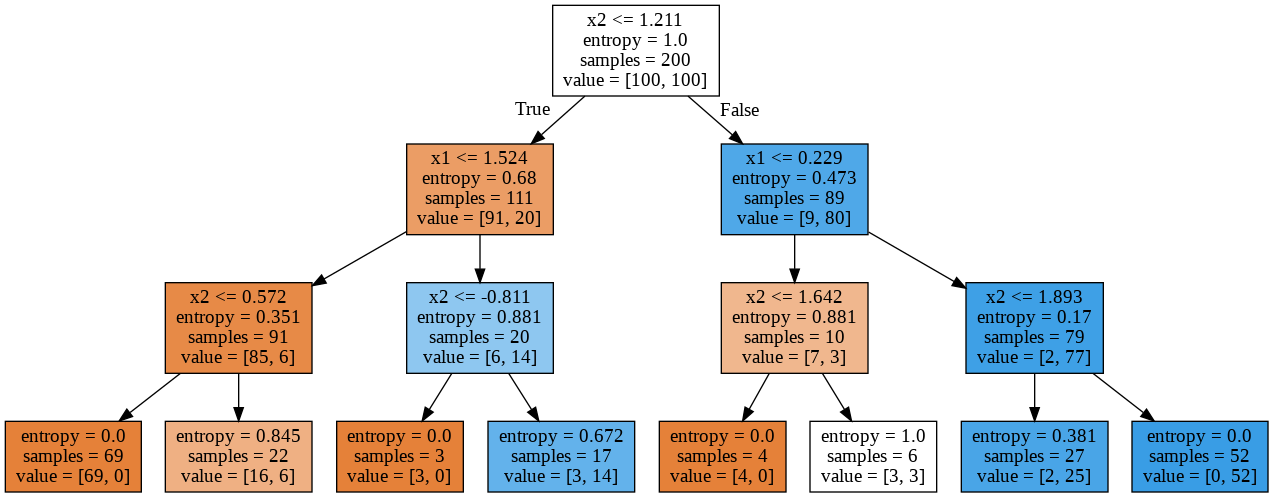

In [ ]:
tree_graph_to_png(tree=clf_tree, feature_names=['x1', 'x2'], 
                  png_file_to_save='decision_tree1.png')

Image("/content/decision_tree1.png")

**Comment pouvons-nous "lire" un tel arbre ?**

Au début, il y avait 200 échantillons (instances), 100 de chaque classe. L'entropie de l'état initial était maximale, $S=1$. Ensuite, la première partition des échantillons en 2 groupes a été réalisée en comparant la valeur de $x_2$ avec celle de $1.211$ (trouver cette partie de la "bordure" dans l’image ci-dessus). Ainsi, l'entropie des groupes de gauche et de droite a diminuée. Le processus se poursuit jusqu'à la profondeur 3. Dans cette visualisation, plus il y a d'échantillons de la première classe, plus la couleur orange du sommet est sombre; plus il y a d'échantillons de la deuxième classe, plus le bleu est foncé. Au début, le nombre d'échantillons des deux classes est identique, le noeud racine de l'arbre est donc blanc.

### B. Exemple du fonctionnement d'un arbre de décision avec des caractéristiques (variables) numériques 

Supposons que nous ayons une caractéristique numérique "Age" qui a plusieurs de valeurs uniques. Un arbre de décision cherchera la meilleure (en fonction de certains critères de gain d’information) en vérifiant les attributs binaires tels que "Age <17", "Age <22,87", etc. Mais que se passe-t-il si la tranche d'âge est large ? Ou que se passe-t-il si une autre variable quantitative, "salaire", peut également être "coupée" de plusieurs manières ? Il y aura trop d'attributs binaires à sélectionner à chaque étape de la construction de l'arborescence. Pour résoudre ce problème, des méthodes heuristiques sont généralement utilisées pour limiter le nombre de seuils auxquels nous comparons la variable quantitative.
 
Prenons un exemple. Supposons que nous ayons le jeu de données (dataset) suivant:

In [ ]:
data = pd.DataFrame({'Age': [17,64,18,20,38,49,55,25,29,31,33],
                     'Loan Default': [1,0,1,0,1,0,0,1,1,0,1]})
data 

,Age,Loan Default
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


Faisons un tri par âge en ordre croissant.

In [ ]:
data.sort_values('Age')

,Age,Loan Default
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


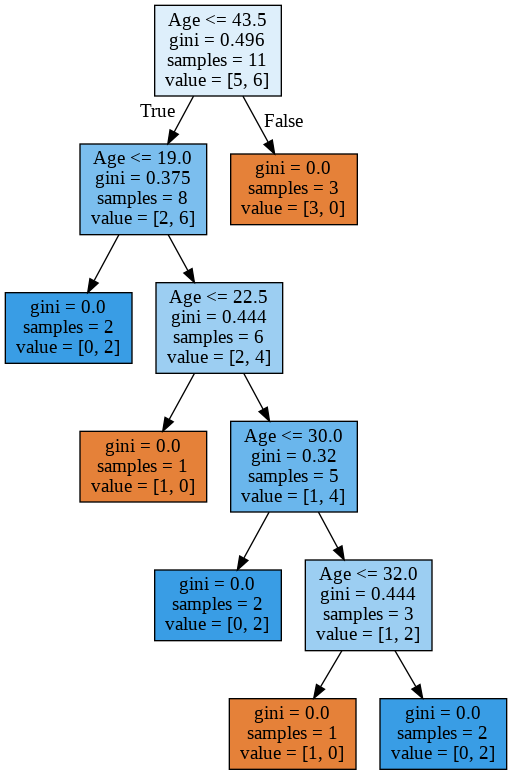

In [ ]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data['Age'].values.reshape(-1, 1), data['Loan Default'].values)

tree_graph_to_png(age_tree, feature_names=['Age'], 
                 png_file_to_save='decision_tree2.png')

Image("/content/decision_tree2.png")

Nous voyons que l’arbre a utilisé les 5 valeurs suivantes pour évaluer l’âge : 43,5, 19, 22,5, 30 et 32 ans. Si vous regardez de plus près, ce sont exactement les valeurs moyennes entre les âges auxquels la classe cible "bascule" de 1 à 0 ou de 0 à 1. Pour illustrer davantage, 43,5 correspond à la moyenne de 38 et 49 ans; un client de 38 ans n'a pas remboursé le prêt alors que le client de 49 ans l'a fait. L'arborescence recherche les valeurs auxquelles la classe cible bascule sa valeur en tant que seuil pour "couper" une variable quantitative.
 

Prenons un exemple plus complexe en ajoutant la variable "Salary" (en milliers de dollars par an).

In [ ]:
data2 = pd.DataFrame({'Age':  [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33], 
                      'Salary': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102, 88],
                      'Loan Default': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]})
data2

,Age,Salary,Loan Default
0,17,25,1
1,64,80,0
2,18,22,1
3,20,36,0
4,38,37,1
5,49,59,0
6,55,74,0
7,25,70,1
8,29,33,1
9,31,102,0


Si nous trions par âge, la classe cible ("loan default") bascule (de 1 à 0 ou vice versa) 5 fois. Et si nous trions par salaire (salary), cela change 7 fois. Comment l’arbre choisira-t-il les caractéristiques maintenant ? Voyons voir.

In [ ]:
data2.sort_values('Age')

,Age,Salary,Loan Default
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


In [ ]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(data2[['Age', 'Salary']].values, data2['Loan Default'].values);

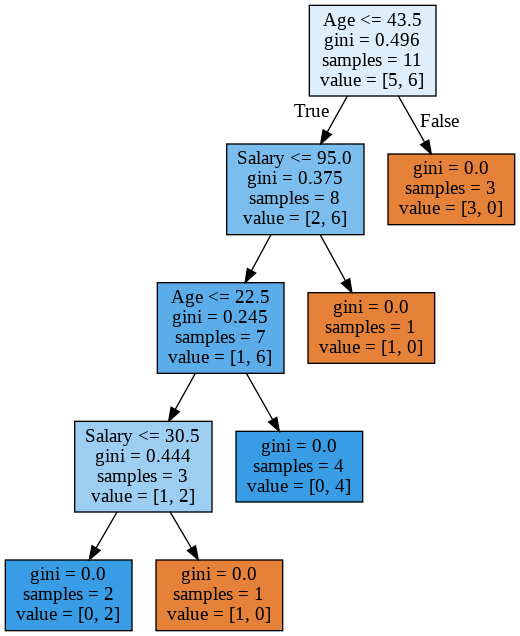

In [ ]:
tree_graph_to_png(tree=age_sal_tree, feature_names=['Age', 'Salary'],
                  png_file_to_save='decision_tree3.png')

Image("/content/decision_tree3.png")

Nous voyons que l’arbre a été divisé par salaire et par âge. De plus, les seuils de comparaison des caractéristiques sont 43,5 et 22,5 ans et 95k et 30,5k par an. Encore une fois, nous voyons que 95 correspond à la moyenne entre 88 et 102; l'individu avec un salaire de 88k s'est avéré être "mauvais" tandis que celui avec 102k était "bon". La même chose vaut pour 30.5k. Autrement dit, seules quelques valeurs de comparaison par âge et par salaire ont été recherchées. Pourquoi l’arbre at-il choisi ces caractéristiques ?  
Parce qu'ils ont donné une meilleure partition (selon l'incertitude de Gini).

**Conclusion**: l'heuristique la plus simple pour la gestion des caractéristiques numériques dans un arbre de décision consiste à trier ses valeurs par ordre croissant et à ne vérifier que les seuils pour lesquels la valeur de la variable cible a changé.

De plus, quand un jeu de données contient de nombreuses caractéristiques numériques, chacune avec de nombreuses valeurs uniques, seuls les top-N des seuils décrits ci-dessus sont sélectionnés, c'est-à-dire n'utilisez que les top-N supérieurs qui donnent un gain maximal. Le processus consiste à construire un arbre de profondeur 1, à calculer l'entropie (ou incertitude de Gini) et à sélectionner les meilleurs seuils pour la comparaison.

Pour illustrer cela, si nous divisons par "Salary $\leq$ 34.5", le sous-groupe de gauche aura une entropie de 0 (tous les clients sont "mauvais") et celui de droite aura une entropie de 0,954 (3 "mauvais" et 5 "bons ", vous pouvez le vérifier vous-même car cela fera partie de la mission). Le gain d'information est d'environ 0,3.
Si nous séparons par "Salary $\leq$ 95", le sous-groupe de gauche aura une entropie de 0,97 (6 "mauvais" et 4 "de bon"), et celui de droite aura une entropie de 0 (un groupe ne contenant qu'un seul objet). Le gain d'information est d'environ 0,11.
Si nous calculons le gain d'informations pour chaque partition de cette manière, nous pouvons sélectionner les seuils pour la comparaison de chaque caractéristique numérique avant la construction d'un grand arbre (en utilisant toutes les caractéristiques).

Des exemples supplémentaires de discrétisation de caractéristiques numériques peuvent être trouvés dans des articles tels que ["A Simple Guide to Entropy-Based Discretization" or "Discretizing a continuous variable using Entropy"](http://kevinmeurer.com/a-simple-guide-to-entropy-based-discretization/) ou ["Discretizing a continuous variable using Entropy"](http://clear-lines.com/blog/post/Discretizing-a-continuous-variable-using-Entropy.aspx). L'un des articles scientifiques les plus en vue sur ce sujet est "On the handling of continuous-valued attributes in decision tree generation" (UM Fayyad. KB Irani, "Machine Learning", 1992).

### C. Exemple de régression


Générons des données distribuées par la fonction $f(x) = e^{-x ^ 2} + 1.5 * e^{-(x - 2) ^ 2}$ avec du bruit (*with noise*). Ensuite, nous allons entraîner cet arbre avec ces données et les prédictions qu’il réalise.

In [ ]:
n_train = 150        
n_test = 1000       
noise = 0.1

def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
    np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

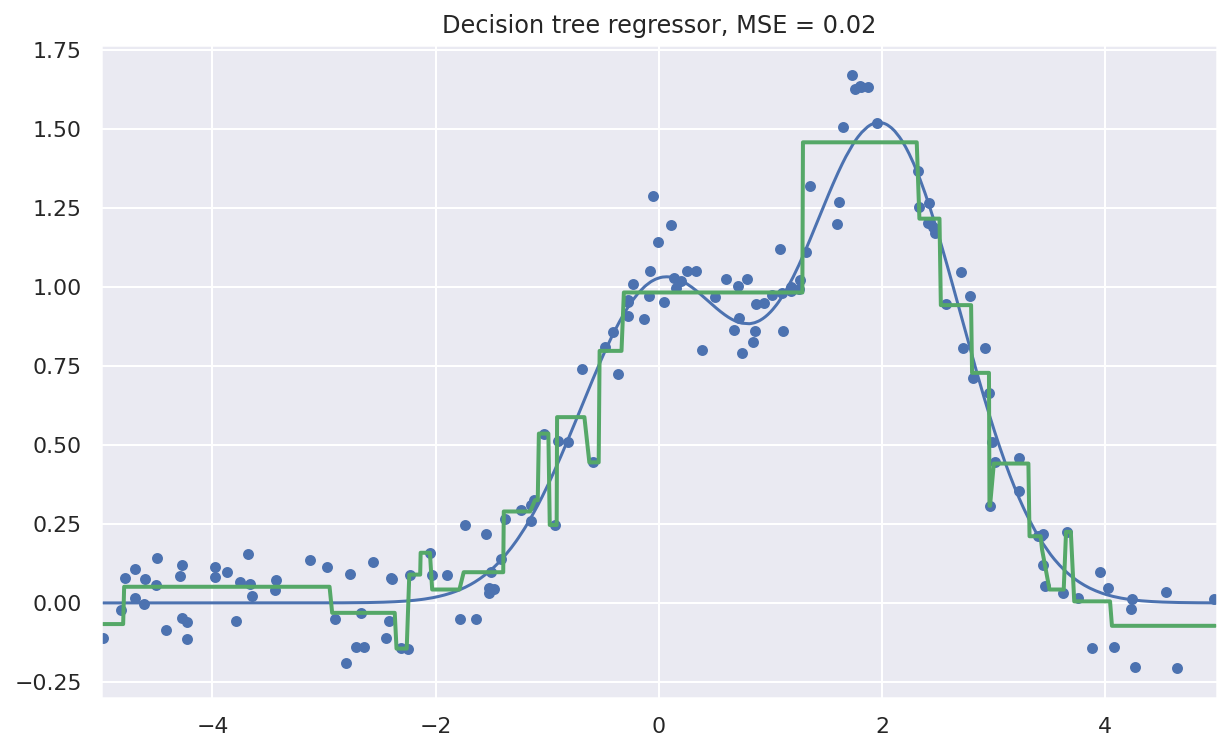

In [ ]:
from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

### Visualization
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), c="b")
# plt.scatter(X_test, y_test, c="r", s=20)
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % (np.sum((y_test - reg_tree_pred) ** 2) / n_test))
plt.show()

Nous voyons que l’arbre de décision rapproche les données d’une fonction constante par morceaux.

### Paramètres importants  de l'arbre de décision

Techniquement, vous pouvez créer un arbre de décision jusqu’à ce que chaque feuille ait exactement une instance, mais cela n’est pas courant en construisant un seul arbre, car il sera *overfitted* (en sur-apprentissage), ou trop ajusté au jeu d’entraînement, et ne pourra pas bien prédire les étiquettes pour les nouvelles données. Au bas de l’arbre, à une certaine profondeur, il y aura des partitions sur des caractéristiques moins importantes (par exemple, si un client est originaire de Leeds ou de New York). Nous pouvons exagérer d'avantage cette histoire et constater que les quatre clients qui sont venus à la banque pour un prêt en pantalon vert n'ont pas remboursé le prêt. Même si cela était vrai lors de l'entraînement, nous ne souhaitons pas que notre modèle de classification génère de telles règles spécifiques.
 
Il existe deux exceptions où les arbres sont construits à la profondeur maximale :
- Random Forest (un groupe d'arbres) calcule la moyenne des réponses d'arbres individuels construits à la profondeur maximale (nous verrons plus loin pourquoi vous devriez le faire).
- *Pruning trees* (Élagage des arbres). Dans cette approche, l'arbre est d'abord construit à la profondeur maximale. Ensuite, de bas en haut, certains nœuds de l’arbre sont supprimés (élagués) en comparant la qualité de l’arbre avec et sans cette partition (la comparaison est effectuée à l’aide de la *cross-validation* (validation croisée), que vous voyons plus bas).

L'image ci-dessous est un exemple de bordure (frontière) de séparation construite dans un arbre sur-appris.

<img align='center' src='https://habrastorage.org/files/f9f/3b5/133/f9f3b5133bae460ba96ab7e546155b1d.png'><br>

Les moyens les plus courants de gérer le sur-apprentissage dans les arbres de décision sont les suivants:
- limitation artificielle de la profondeur ou un nombre minimal d'échantillons dans les feuilles : la construction d'un arbre s'arrête juste à un moment donné;
- élagage de l'arbre

## 2. La méthode des plus proches voisins (KNN)



### La classe `KNeighborsClassifier` dans Scikit-learn 

Les principaux paramètres de la classe `sklearn.neighbors.KNeighborsClassifier` sont les suivants:
- weights: `uniform` (tous les poids sont égaux), `distance` (le poids est inversement proportionnel à la distance à l'échantillon de test) ou toute autre fonction définie par l'utilisateur;
- algorithm (facultatif): `brute`, `ball_tree`, `KD_ tree` ou `auto`. Dans le premier cas, les voisins les plus proches pour chaque cas de test sont calculés par une recherche sur la grille sur l'ensemble du jeu d'apprentissage ou d'entraînement. Dans les deuxièmes et troisième cas, les distances entre les exemples sont stockées dans un arbre pour accélérer la recherche des voisins les plus proches. Si vous définissez ce paramètre sur `auto`, la bonne façon de trouver les voisins sera automatiquement choisie en fonction du jeu d’entraînement.
- leaf_size (facultatif): seuil pour passer à la recherche sur la grille si l'algorithme de recherche de voisins est BallTree ou KDTree;
- metric : (métrique) `minkowski`,` manhattan`, `euclidien`,` chebyshev` ou autre.

### Exemple de la classification

Considérons l’entraînement de la methode KNN sur les mêmes données synthétiques que dans l'exemple de l'arbre de decision.

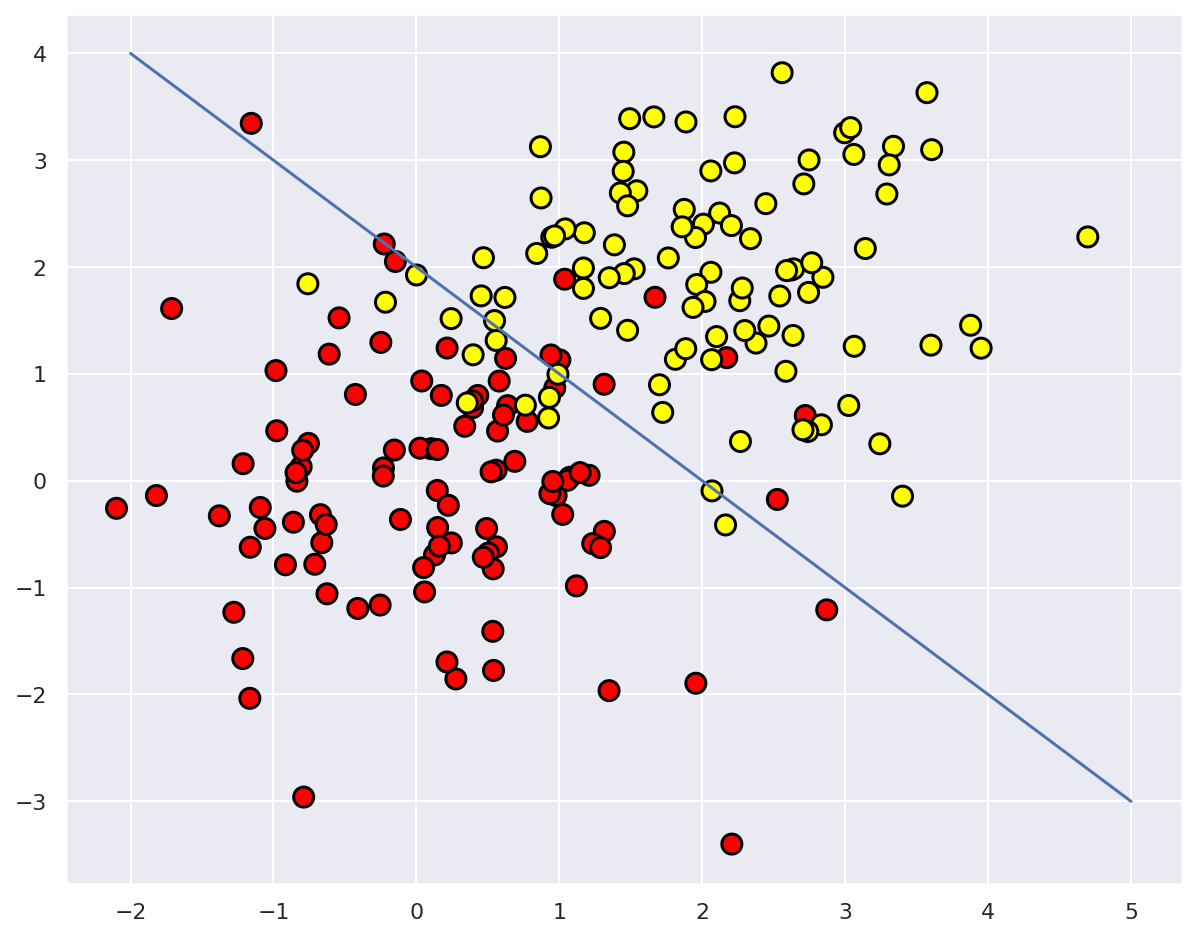

In [ ]:
# first class
np.random.seed(17)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# adding second class
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

plt.figure(figsize=(10,8))
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,6), range(4,-4,-1));

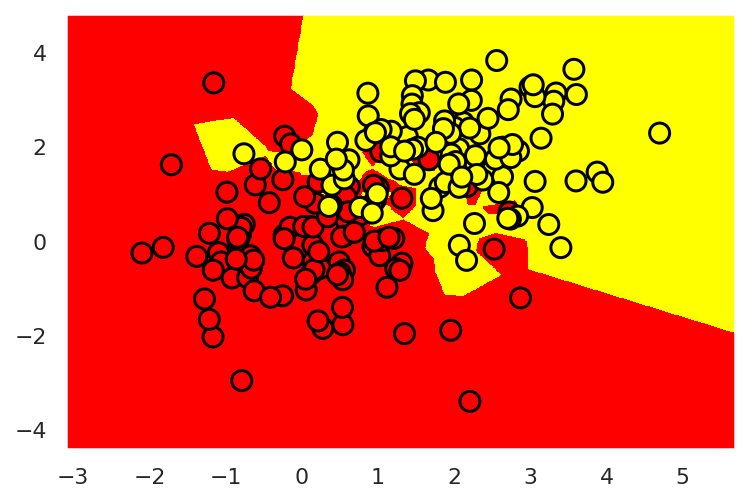

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Ecrivons une fonction auxiliaire qui retournera la grille pour plus de visualisation.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

knn = KNeighborsClassifier(n_neighbors=1) #try n_neighbors=10
knn.fit(train_data, train_labels)

xx, yy = get_grid(train_data)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);

### Paramètres importants  du KNN

La qualité de la classification/régression avec k-NN dépend de plusieurs paramètres:

- Le nombre de voisins $k$.
- La distance mesurée entre les échantillons (les distances communes incluent les distances de Hamming, Euclidienne, Cosinus et Minkowski). Notez que la plupart de ces métriques exigent que les données soient mises à l'échelle. En termes simples, nous ne voulons pas que la caractéristique «salaire», qui est de l’ordre de milliers, affecte davantage la distance que «l’âge», qui est généralement inférieur à 100.
- Poids des voisins (chaque voisin peut avoir des poids différents : par exemple, plus l'échantillon est large, plus le poids est bas).

### La méthode des plus proches voisins dans les applications réelles 

- k-NN peut servir de bon point de départ (base) dans certains cas;
- Dans les compétitions Kaggle, le k-NN est souvent utilisé pour la construction de méta-caractéristiques (prédictions de k-NN en tant qu'entrée dans d'autres modèles) ou pour l'empilement / le mélange;
- La méthode des plus proches voisins s'étend à d'autres tâches telles que les systèmes de recommandation. La décision initiale pourrait être une recommandation d'un produit (ou service) populaire parmi les *plus proches voisins* de la personne pour laquelle nous souhaitons faire une recommandation;
- En pratique, sur de grands ensembles de données, des méthodes de recherche approximatives sont souvent utilisées pour les plus proches voisins. Un certain nombre de bibliothèques open source implémentent de tels algorithmes; consultez la bibliothèque de Spotify [Annoy](https://github.com/spotify/annoy).

## 3. Choix des paramètres du modèle et validation croisée





La validation croisée est une technique très importante en apprentissage automatique et peut également être appliquée en statistique et en économétrie. Cela facilite le réglage de l'hyperparamètre, la comparaison des modèles, l'évaluation des fonctionnalités, etc. Plus de détails sont disponibles [ici](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part1.html) (article de blog de Sebastian Raschka) ou dans n'importe quel manuel classique sur l'apprentissage automatique (ou de statistique).

On pourra voir l'application de la validation croisée cross_val_score du bibliothèque sklearn dans les exemples ci-dessous.

## 4. Exemple d'application et cas complexes



### A. Exemple d'application des methodes au jeu de données sur le taux de désabonnement des clients d'opérateurs téléphoniques.

Utilisation des arbres de décision et de la méthode des plus proches voisins dans une tâche de prédiction de désabonnement client (taux d'attrition).


Lisons les données dans un `DataFrame` et pré-traitons-les. Stockez la caractéristique *State* dans un objet `Series` séparé pour le moment et supprimez-le du dataframe. Nous allons entraîner le premier modèle sans la caractéristique *State*, puis nous verrons si cela peut aider.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/telecom_churn.csv")

df['International plan'] = pd.factorize(df['International plan'])[0]
df['Voice mail plan'] = pd.factorize(df['Voice mail plan'])[0]
df['Churn'] = df['Churn'].astype('int')
states = df['State']
y = df['Churn']
df.drop(['State', 'Churn'], axis=1, inplace=True)

In [ ]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


Allouons 70% du jeu d'entraînement (`X _train`,` y_ train`) et 30% au jeu de test (`X _holdout`,` y_holdout`). Le jeu de données de test ne sera pas impliqué dans le réglage des paramètres des modèles. Nous l'utilisons à la fin, après le réglage, pour évaluer la qualité du modèle obtenu. Entraînons 2 modèles : arbre de décision et k-NN. Nous ne savons pas quels paramètres sont bons, nous allons donc en supposer quelques uns  de manière aléatoire : une profondeur d'arbre de 5 et le nombre de plus proches voisins de 10.

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3,
random_state=17)

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)

# for kNN, we need to scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

Évaluons la qualité des prévisions sur notre jeu de données avec une métrique simple, la proportion de réponses correctes (exactitude ou précision). L’arbre de décision s’est mieux comporté : le pourcentage de réponses correctes est d’environ 94% (arbre de décision) contre 89% (k-NN). Notez que cette performance est obtenue en utilisant des paramètres aléatoires.

In [ ]:
from sklearn.metrics import accuracy_score

tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.94

In [ ]:
knn_pred = knn.predict(X_holdout_scaled)
accuracy_score(y_holdout, knn_pred)

0.89

Identifions maintenant les paramètres de l’arbre en utilisant la **validation croisée**. Nous allons ajuster la profondeur maximale et le nombre maximal d’entités utilisées à chaque division (partition ou partage). 

Voici l'essentiel du fonctionnement de GridSearchCV : pour chaque paire unique de valeurs `max_depth` et `max_features`, calculez les performances du modèle avec une 5-fold validation croisée, puis sélectionnez la meilleure combinaison de paramètres.

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {'max_depth': range(1,11),
               'max_features': range(4,19)}

tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)


Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    6.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_fea

Énumérons les meilleurs paramètres et la précision moyenne correspondante à partir de la validation croisée.

In [ ]:
tree_grid.best_params_ 

{'max_depth': 6, 'max_features': 17}

In [ ]:
tree_grid.best_score_ 

0.94257014456259

In [ ]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.946

Affichons l'arbre résultant. Comme il ne s’agit pas uniquement d’un exemple basé sur un jeu (sa profondeur maximale est de 6), l'image n’est pas si petite, mais vous pouvez "naviguer" sur l’arbre en cliquant sur l'image.

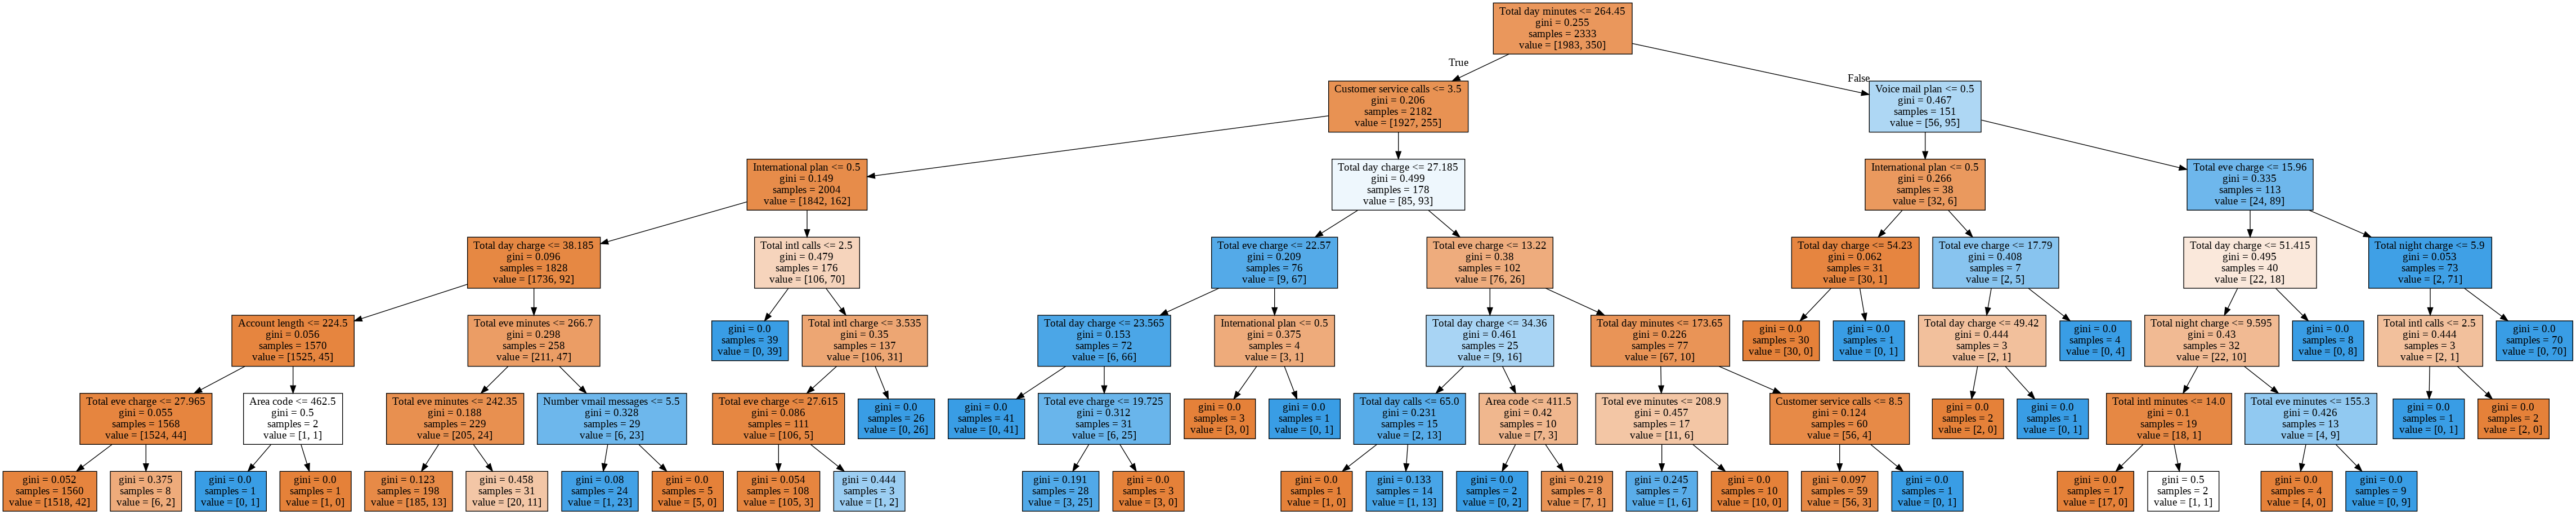

In [ ]:
tree_graph_to_png(tree=tree_grid.best_estimator_, feature_names=df.columns,
                 png_file_to_save='decision_tree4.png')

Image("/content/decision_tree4.png")

Maintenant, ajustons le nombre de voisins $k$ pour k-NN:

In [ ]:
from sklearn.pipeline import Pipeline

knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

knn_params = {'knn__n_neighbors': range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params,
                        cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(X_train, y_train)

knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    2.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.9s finished


({'knn__n_neighbors': 7}, 0.8859867109023905)

In [ ]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))

0.89

Ici, l’arbre s’est avéré meilleur que l’algorithme des plus proches voisins : exactitude de 94,2%/94,6% pour la validation croisée et le hold-out respectivement. Les arbres de décision fonctionnent très bien et même les forêts aléatoires ou random forest (considérons-le pour le moment comme un groupe d’arbres qui fonctionnent mieux ensemble) dans cet exemple ne peuvent pas atteindre de bien meilleures performances (95,1%/95,3%) bien qu’elles aient été entraînées beaucoup plus longtemps.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                                random_state=17)
print(np.mean(cross_val_score(forest, X_train, y_train, cv=5)))

0.9494233119813256


In [ ]:
forest_params = {'max_depth': range(6, 12),
                 'max_features': range(4, 19)}

forest_grid = GridSearchCV(forest, forest_params,
                           cv=5, n_jobs=-1, verbose=True)

forest_grid.fit(X_train, y_train)

forest_grid.best_params_, forest_grid.best_score_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  4.8min finished


({'max_depth': 9, 'max_features': 6}, 0.9511372931045574)

In [ ]:
accuracy_score(y_holdout, forest_grid.predict(X_holdout))

0.953

### B. Exemple : Cas complexes pour les arbres de décision 

Pour poursuivre la discussion sur les avantages et les inconvénients des méthodes en question, considérons une tâche de classification simple, dans laquelle un arbre fonctionnerait bien mais le faisait de manière "trop compliquée". Créons un ensemble de points sur un plan (2 entités), chaque point sera l’une des deux classes (+1 pour le rouge ou -1 pour le jaune). Si vous le considérez comme un problème de classification, cela semble très simple : les classes sont séparées par une ligne.

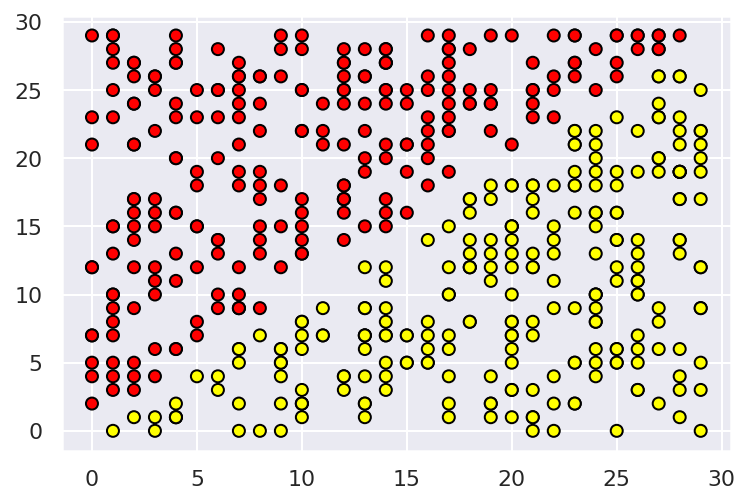

In [ ]:
def form_linearly_separable_data(n=500, x1_min=0, x1_max=30, 
                                 x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1 = np.random.randint(x1_min, x1_max)
        x2 = np.random.randint(x2_min, x2_max)
        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)

X, y = form_linearly_separable_data()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolors='black');

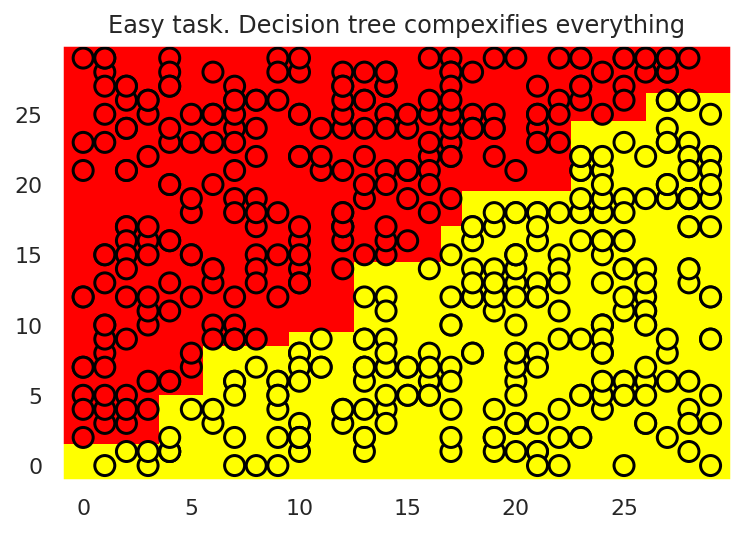

In [ ]:
#from sklearn.tree import DecisionTreeClassifier

def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

tree = DecisionTreeClassifier(random_state=17).fit(X, y)

xx, yy = get_grid(X, eps=0.05)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.title('Easy task. Decision tree compexifies everything');

Cependant, la frontière créée par l'arbre de décision est trop compliquée; et l'arbre lui-même est très profond. En outre, imaginez à quel point l’arbre se généralisera pour un espace au-delà des carrés $30 \times 30$ qui encadrent le jeu de données d’entraînement.

Nous avons obtenons cette construction trop complexe, bien que la solution soit juste une ligne doite de la forme $x_1 = x_2$.

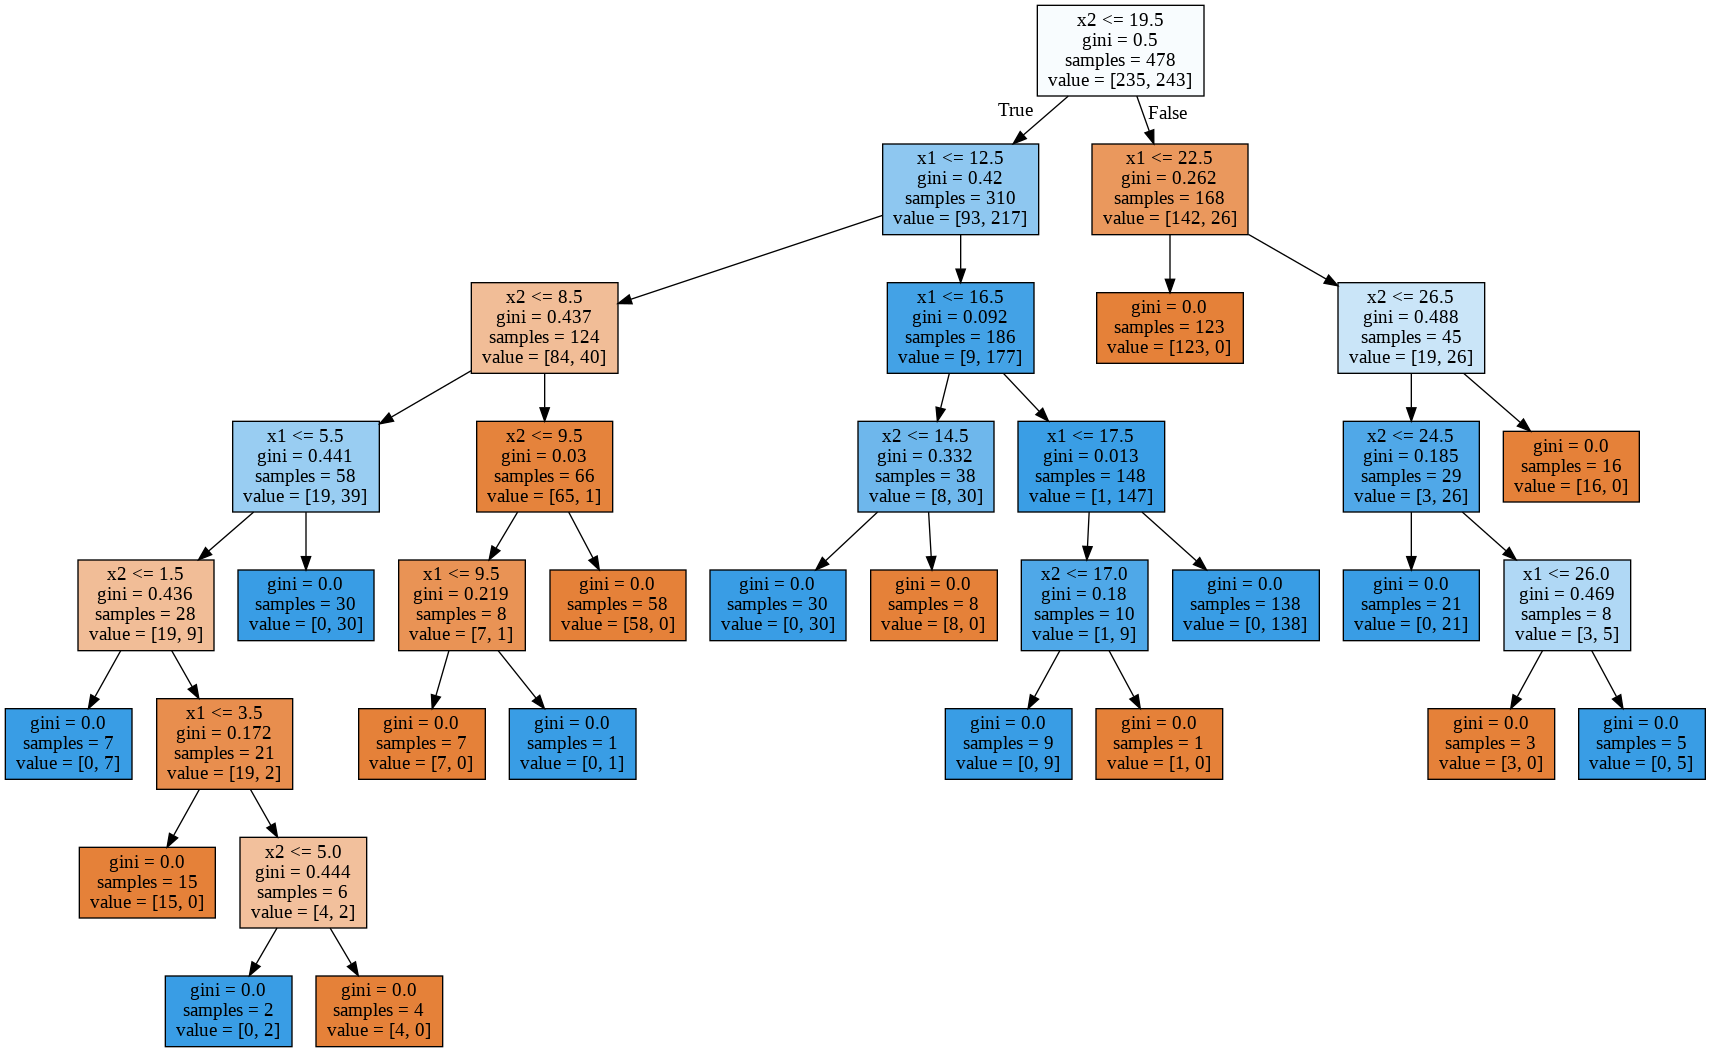

In [ ]:
tree_graph_to_png(tree=tree, feature_names=['x1', 'x2'],
         png_file_to_save='decision_tree5.png')

Image("/content/decision_tree5.png")

La méthode du voisin le plus proche est meilleure que l’arbre, mais n’est pas aussi efficace qu’un classifieur linéaire.

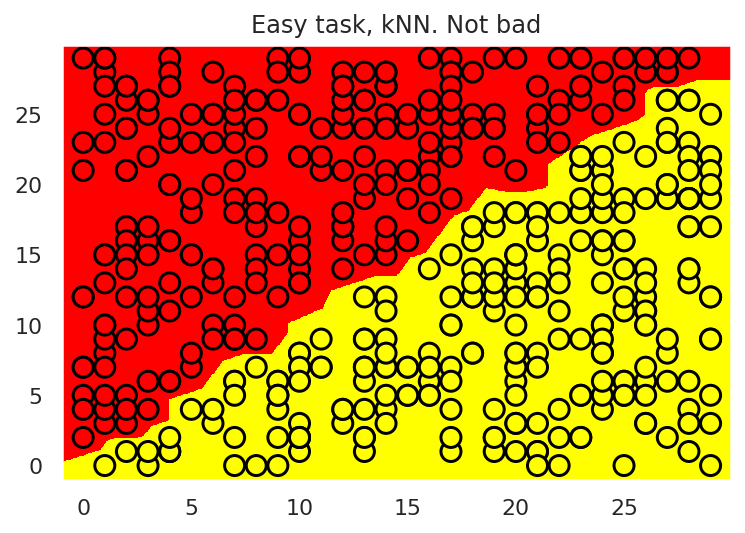

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

xx, yy = get_grid(X, eps=0.05)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);
plt.title('Easy task, kNN. Not bad');

### C. Exemple : Cas complexe pour les plus proches voisins </div>

Considérons un autre exemple simple. Dans le problème de la classification, une des caractéristiques sera simplement proportionnelle au vecteur de réponses, mais cela n’aidera pas pour la méthode des plus proches voisins.

In [ ]:
def form_noisy_data(n_obj=1000, n_feat=100, random_seed=17):
    np.seed = random_seed
    y = np.random.choice([-1, 1], size=n_obj)

    # first feature is proportional to target
    x1 = 0.3 * y

    # other features are noise
    x_other = np.random.random(size=[n_obj, n_feat - 1])

    return np.hstack([x1.reshape([n_obj, 1]), x_other]), y

X, y = form_noisy_data()

print("Data shape : ", X.shape )

Data shape :  (1000, 100)


Comme toujours, nous examinerons la précision de la validation croisée et du jeu données de test. Construisons des courbes reflétant la dépendance de ces quantités sur le paramètre `n_neighbors` dans la méthode des plus proches voisins. Ces courbes s'appellent des courbes de validation.

On peut voir que k-NN avec la distance euclidienne ne fonctionne pas bien sur le problème, même si vous faites varier le nombre des plus proches voisins sur une large plage. En revanche, l’arbre de décision "détecte" facilement les dépendances cachées dans les données malgré une restriction de la profondeur maximale.

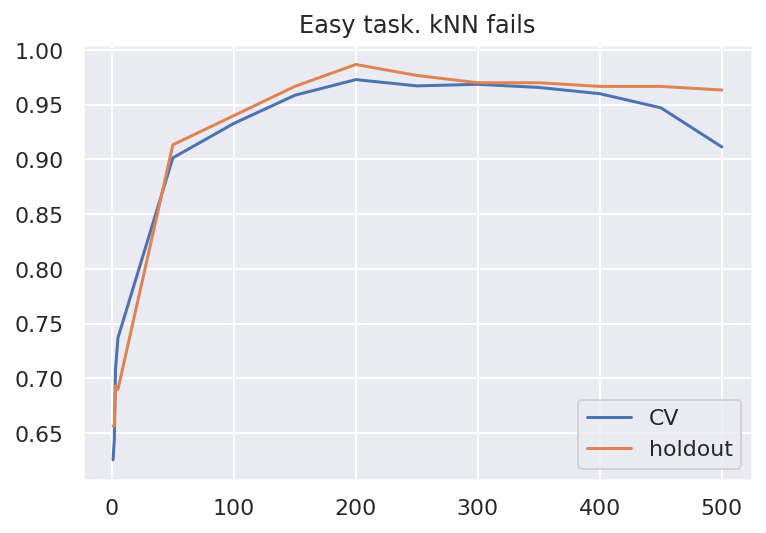

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)

from sklearn.model_selection import cross_val_score

cv_scores, holdout_scores = [], []
n_neighb = [1, 2, 3, 5] + list(range(50, 550, 50))

for k in n_neighb:

    knn_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('knn', KNeighborsClassifier(n_neighbors=k))])
    cv_scores.append(np.mean(cross_val_score(knn_pipe, X_train, y_train, cv=5)))
    knn_pipe.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn_pipe.predict(X_holdout)))

plt.plot(n_neighb, cv_scores, label='CV')
plt.plot(n_neighb, holdout_scores, label='holdout')
plt.title('Easy task. kNN fails')
plt.legend();

In [ ]:
tree = DecisionTreeClassifier(random_state=17, max_depth=1)
tree_cv_score = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
tree.fit(X_train, y_train)
tree_holdout_score = accuracy_score(y_holdout, tree.predict(X_holdout))
print('Decision tree. CV: {}, holdout: {}'.format(tree_cv_score, tree_holdout_score))

Decision tree. CV: 1.0, holdout: 1.0


Dans le second exemple, l’arbre a parfaitement résolu le problème alors que k-NN rencontrait des difficultés. Cependant, très probablement, il s’agit là d’un inconvénient de l’utilisation de la distance euclidienne, qui ne nous a pas permis de révéler qu'une caractéristique était bien meilleure que les autres.